# Honours Project 
## Author: Emily Cooper
## Supervisor: Geoffrey Vasil
### Topic: Discrete model simulation
This notebook is part of a honours project in applied mathematics at the University of Sydney. 

Abstract: The displacement of people in humanitarian crises has pervaded history. However, little has been done to model how such a crisis evolves as people under threat make the decision to flee. We use a discrete SEIR model to derive a partial differential equation of the number of people within a population who have fled. We then discuss the microscopic implications of our macroscopic model. By analysing through both deterministic and stochastic frameworks, we interpret characteristics of our model and its parameters on both microscopic and macroscopic levels. In particular, we discuss how our model suggests an internal utility variable that individuals carry around with them describing risks and opportunity. We speculate about how these results may conform with Rational Choice Theory or its generalisation, the Prospect Theory of Kahneman and Tversky. We then simulate fabricated crisis events through the discrete model, investigating four customisations of our generalised framework to simulate real-world scenarios. 


In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.integrate import quad

In [4]:
class discrete_refugee:

    def __init__(self, bins = np.linspace(0.1,1,5), num_people = 2000, p = [], danger_time = 2.5, escape_param = 0.9, with_return = 0, scope = 2, danger_form = "two_spike", escape_form = "threshold", return_form = "all_start", safety_form = "average"):
        
        # Allow random split into bins if necessary 
        if len(p) != 0:
            self.p_dis = p
        else:
            rand_state = np.random.rand(len(bins))
            self.p_dis = rand_state/np.sum(rand_state)*num_people
            self.p_dis = self.p_dis/np.sum(self.p_dis)

        # Setting up attributes of the system 
        self.bins = bins
        self.num_states = len(bins)
        self.time = 0
        self.total_pop = num_people
        self.danger_time = danger_time
        self.escape_param = escape_param
        self.scope = scope

        # Setting up functional form choices for D, S, \varphi, \gamma
        self.danger_form = danger_form
        self.escape_form = escape_form
        self.return_form = return_form
        self.safety_form = safety_form

        # Setting up integ function 

        # Quantities needed for return function 
        self.ret = with_return
        self.lag = 3
        self.first_time = True
        self.prev = 0
        self.t0 = 0

        # Initial states of each of the variables of interest 
        self.u = num_people*self.p_dis
        self.initdis = np.copy(self.u)
        self.e = np.zeros(len(bins))
        self.r = 0

        # Memory term of time
        self.e_mem = np.zeros((len(bins),3))
        self.dt = 1e-3
       
    
    def danger(self,bin):
        if self.danger_form == "two_spike":
            return 0.5*bin**2/(1 + (self.time - 3)**2) + 0.5*bin**2/(1 + (self.time - self.danger_time)**2)
        elif self.danger_form == "wiggly":
            return  self.time +  bin*np.sin(self.time*self.danger_time)  
        elif self.danger_form == "periodic":
            return np.minimum(bin*np.sin(self.danger_time*self.time)**2 + bin, 1)
        elif self.danger_form == "sigmoid":
            return np.minimum(bin/(bin + np.exp(-self.time + self.danger_time)), 1)
        elif self.danger_form == "sigmoid_pert":
            return np.maximum(np.minimum(bin/(bin + np.exp(-self.time + self.danger_time)) + np.random.normal(), 1),0)

    def safety(self,bin):
        pos = np.argmax(bin == self.bins)
        if self.safety_form == "average":
            nearest_neighbours = np.sum(self.u[max(pos - (self.scope - 1),0): min(pos + self.scope, self.num_states - 1)])/np.sum(self.initdis[max(pos - (self.scope - 1),0): min(pos + self.scope, self.num_states-1)])
            return nearest_neighbours 
        elif self.safety_form == "deriv":
            return (self.e_mem[pos,0] - 2*self.e_mem[pos,1] + self.e_mem[pos,2])/self.dt**2

    def escape(self, bin):
        if self.escape_form == "threshold":
            if bin >= self.escape_param:
                return 1
            else:
                return 0
        elif self.escape_form == "integ":
            def dang(t, bin):
                 return self.danger(bin)
            return quad(dang, 0, self.time, args = (bin, ))[0]
        elif self.escape_form == "integ_frac":
            def dang(t, bin):
                 return self.danger(bin)/(1+t**2)
            return quad(dang, 0, self.time, args = (bin, ))[0]
        elif self.escape_form == "integ_e":
             def dang(t, bin):
                 return self.danger(bin)*np.exp(-t)
             return quad(dang, 0, self.time, args = (bin, ))[0]
    
    def returns(self):
        cond = np.mean([self.danger(b) for b in self.bins]) < 0.2
        if cond and self.first_time:
            if self.time > self.lag:
                self.t0 = self.time
                self.first_time = False
            else:
                cond = 0
        elif not cond and not self.first_time:
            self.first_time = True
        if cond:
            self.prev = cond*self.r*(self.time - self.t0)*0.01
            return self.prev
        else:
            new_one = self.prev/(1+1e-3)
            self.prev = new_one
            return new_one

    def step(self, dt = 1e-3):

        # Set backwards and forwards and account for boundary conditions
        danger_roll_back = np.roll(self.danger(self.bins),shift = 1)
        safety_roll_back = np.roll(np.array([self.safety(bin) for bin in self.bins]),shift = 1)
        e_roll_forward = np.roll(self.e, shift = -1)
        e_roll_back = np.roll(self.e, shift = 1)
        danger_roll_back[0], safety_roll_back[0], e_roll_forward[-1] = 0, 0, 0


        up_change = self.danger(self.bins)*self.u
        last_step = self.danger(self.bins)*self.e

        self.r += dt*np.sum([*np.array([self.escape(bin) for bin in self.bins])*self.e, last_step[-1]]) - self.ret*self.returns()
        self.u -= dt*up_change 


        if self.return_form == "all_start":
            self.u[0] += self.ret*self.returns()
        elif self.return_form == "all_end":
            self.u[-1] += self.ret*self.returns()
        elif self.return_form == "split":
            self.u += self.ret.self.returns()/self.num_states


        self.e += dt*(up_change + danger_roll_back*e_roll_back-self.danger(self.bins)*self.e + self.safety(self.bins)*e_roll_forward  - safety_roll_back*self.e - np.array([self.escape(bin) for bin in self.bins])*self.e)
        self.e_mem = np.roll(self.e_mem, axis = 1)
        self.e_mem[:,0] = self.e
        self.time += dt

    def plot_safety(self,niters):
        safetys = np.zeros(niters)
        for i in range(niters):
            self.step()
            safetys[i] = np.mean(np.array([self.safety(bin) for bin in self.bins]))
        return safetys

    def move(self, niters):
        e_s = np.zeros((niters, self.num_states))
        u_s = np.zeros((niters, self.num_states))
        r = np.zeros(niters)
        for i in range(niters):
            r[i] = self.r
            u_s[i,:] = self.u
            e_s[i,:] = self.e
            self.step()
        return u_s, e_s, r

# Wiggly danger

In [40]:
ds = np.array([*np.linspace(1, 3.5, 10), *np.arange(4, 14)])
params = [np.linspace(0.1,1,5), 2000, 0.2*np.ones(5), 0, 0.9, 0, 2, "wiggly", "threshold", "all_start"]
stabilising_wiggle = []
max_e_wiggle = []
when_max_e_wiggle = []
for d in ds:
    params[3] = d
    u_wiggle, e_wiggle, r_wiggle = plot_results(params, "wiggly_danger", round(d, 2), 3*10**4)
    stabilising_wiggle.append(np.min(np.where(np.diff(r_wiggle)/r_wiggle[1:] < 1e-6))*1e-3)
    max_e_wiggle.append(np.max(e_wiggle, axis = 0))
    when_max_e_wiggle.append(np.where(e_wiggle == np.max(e_wiggle, axis = 0)))

/var/folders/y3/gvvyzm1s5sz1w7fzh7mmq1nr0000gn/T/ipykernel_1176/1776600267.py:9: RuntimeWarning: invalid value encountered in divide
  stabilising_wiggle.append(np.min(np.where(np.diff(r_wiggle)/r_wiggle[1:] < 1e-6))*1e-3)


In [ ]:
es = np.array(max_e_wiggle)
when_max = np.array([i[0] for i in when_max_e_wiggle])
bins = np.linspace(0.1,1,5)
colors = sns.color_palette("crest", 5)
fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ax.plot(ds, es[:,1: ], label = ["Bin = " + str(b) for b in bins[1:]])
ax.legend()
ax.set_xlabel("Frequency of oscillations ($a$)")
ax.set_ylabel("Maximum value of $E(P,t)$")
plt.savefig("Runs/wiggly_danger/max.png", dpi = 300)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ax.plot(ds, when_max[:,:-1]*1e-3, label = ["Bin = " + str(b) for b in bins[1:]])
ax.legend()
ax.legend()
ax.set_xlabel("Frequency of oscillations ($a$)")
ax.set_ylabel("Time taken to reach maximum value of $E(P,t)$")
plt.savefig("Runs/wiggly_danger/max_time.png", dpi = 300)

# Periodic Danger

In [83]:
ds = np.array([*np.linspace(1, 3.5, 10), *np.arange(4, 14)])
params = [np.linspace(0.1,1,5), 2000, 0.2*np.ones(5), 0, 0.9, 0, 2, "periodic", "threshold", "all_start"]
stabilising_periodic = []
max_e_periodic= []
when_max_e_periodic = []
for d in ds:
    params[3] = d
    u_periodic, e_periodic, r_periodic = plot_results(params, "periodic_danger", round(d, 2), 3*10**4)
    stabilising_periodic.append(min(np.where(np.diff(r_periodic)/r_periodic[1:] < 1e-6))*1e-3)
    max_e_periodic.append(np.max(e_periodic, axis = 0))
    when_max_e_periodic.append(np.where(e_periodic == np.max(e_periodic, axis = 0)))

/var/folders/y3/gvvyzm1s5sz1w7fzh7mmq1nr0000gn/T/ipykernel_1176/1142084543.py:9: RuntimeWarning: invalid value encountered in divide
  stabilising_periodic.append(min(np.where(np.diff(r_periodic)/r_periodic[1:] < 1e-6))*1e-3)


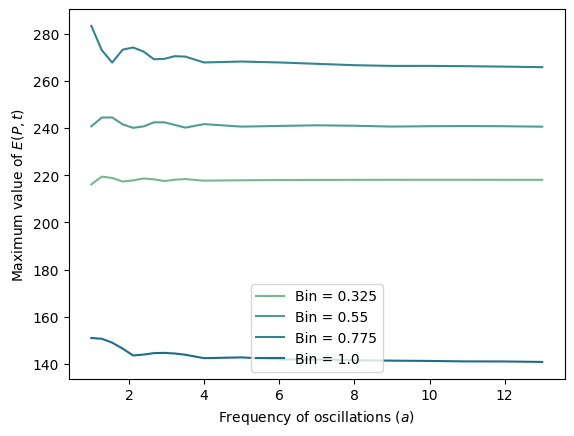

In [86]:
es = np.array(max_e_periodic)
when_max = np.array([i[0] for i in when_max_e_periodic])
bins = np.linspace(0.1,1,5)
colors = sns.color_palette("crest", 5)
fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ax.plot(ds, es[:,1: ], label = ["Bin = " + str(b) for b in bins[1:]])
ax.legend()
ax.set_xlabel("Frequency of oscillations ($a$)")
ax.set_ylabel("Maximum value of $E(P,t)$")
plt.savefig("Runs/periodic_danger/max.png", dpi = 300)
plt.show()

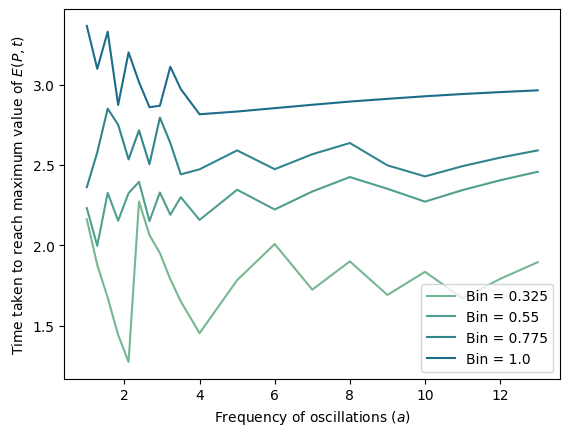

In [87]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ax.plot(ds, when_max[:,:-1]*1e-3, label = ["Bin = " + str(b) for b in bins[1:]])
ax.legend()
ax.legend()
ax.set_xlabel("Frequency of oscillations ($a$)")
ax.set_ylabel("Time taken to reach maximum value of $E(P,t)$")
plt.savefig("Runs/periodic_danger/max_time.png", dpi = 300)

# Sigmoid danger

In [5]:
ds = np.array([*np.linspace(1, 3.5, 10), *np.arange(4, 14)])
params = [np.linspace(0.1,1,5), 2000, 0.2*np.ones(5), 0, 0.9, 0, 2, "sigmoid", "threshold", "all_start"]
stabilising_sig = []
max_e_sig =  []
when_max_e_sig= []
for d in ds:
    params[3] = d
    u_sig, e_sig, r_sig = plot_results(params, "sigmoid_danger", round(d, 2), 3*10**4)
    stabilising_sig.append(min(np.where(np.diff(r_sig)/r_sig[1:] < 1e-6))*1e-3)
    max_e_sig.append(np.max(e_sig, axis = 0))
    when_max_e_sig.append(np.where(e_sig == np.max(e_sig, axis = 0)))

NameError: name 'plot_results' is not defined

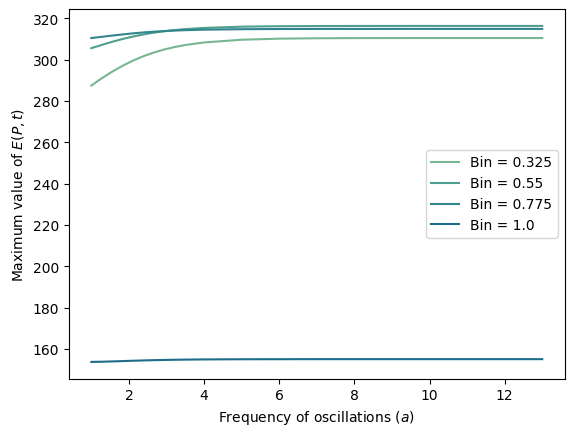

In [135]:
es = np.array(max_e_sig)
when_max = np.array([i[0] for i in when_max_e_sig])
bins = np.linspace(0.1,1,5)
colors = sns.color_palette("crest", 5)
fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ax.plot(ds, es[:,1: ], label = ["Bin = " + str(b) for b in bins[1:]])
ax.legend()
ax.set_xlabel("Frequency of oscillations ($a$)")
ax.set_ylabel("Maximum value of $E(P,t)$")
plt.savefig("Runs/sigmoid_danger/max.png", dpi = 300)
plt.show()

[2.348 3.336 3.851 4.46  4.945]


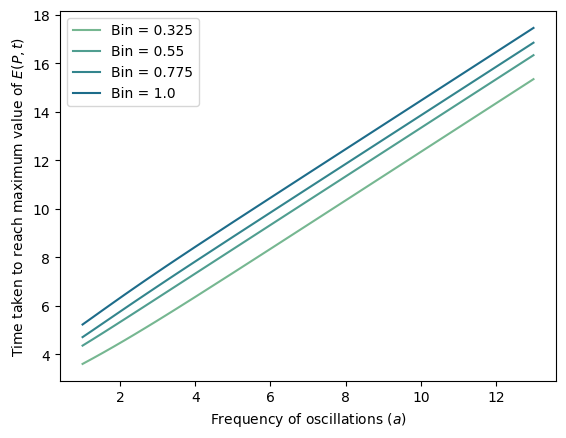

In [140]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ax.plot(ds, when_max[:,:-1]*1e-3, label = ["Bin = " + str(b) for b in bins[1:]])
ax.legend()
ax.legend()
ax.set_xlabel("Frequency of oscillations ($a$)")
ax.set_ylabel("Time taken to reach maximum value of $E(P,t)$")
plt.savefig("Runs/sigmoid_danger/max_time.png", dpi = 300)
(when_max[15,1]*1e-3 - when_max[10,1]*1e-3)/(ds[15] - ds[10])
print(when_max[15,:]*1e-3 - ds[15])

# Sigmoid with pertubation


In [126]:
ds = np.array([*np.linspace(1, 3.5, 10), *np.arange(4, 14)])
params = [np.linspace(0.1,1,5), 2000, 0.2*np.ones(5), 0, 0.9, 0, 2, "sigmoid_pert", "threshold", "all_start"]
stabilising_sig_p = []
max_e_sig_p =  []
when_max_e_sig_p= []
for d in ds:
    params[3] = d
    u_sig_p, e_sig_p, r_sig_p = plot_results(params, "sigmoid_danger_pert", round(d, 2), 3*10**4)
    stabilising_sig_p.append(min(np.where(np.diff(r_sig_p)/r_sig_p[1:] < 1e-6))*1e-3)
    max_e_sig_p.append(np.max(e_sig_p, axis = 0))
    when_max_e_sig_p.append(np.where(e_sig_p == np.max(e_sig_p, axis = 0)))

/var/folders/y3/gvvyzm1s5sz1w7fzh7mmq1nr0000gn/T/ipykernel_1176/3449009167.py:9: RuntimeWarning: invalid value encountered in divide
  stabilising_sig_p.append(min(np.where(np.diff(r_sig_p)/r_sig_p[1:] < 1e-6))*1e-3)


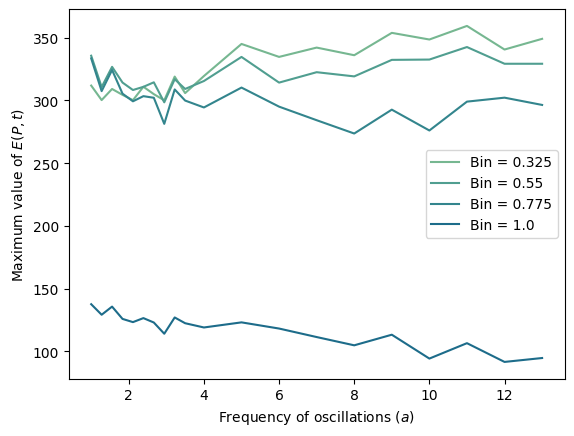

In [127]:
es = np.array(max_e_sig_p)
when_max = np.array([i[0] for i in when_max_e_sig_p])
bins = np.linspace(0.1,1,5)
colors = sns.color_palette("crest", 5)
fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ax.plot(ds, es[:,1: ], label = ["Bin = " + str(b) for b in bins[1:]])
ax.legend()
ax.set_xlabel("Frequency of oscillations ($a$)")
ax.set_ylabel("Maximum value of $E(P,t)$")
plt.savefig("Runs/sigmoid_danger_pert/max.png", dpi = 300)
plt.show()

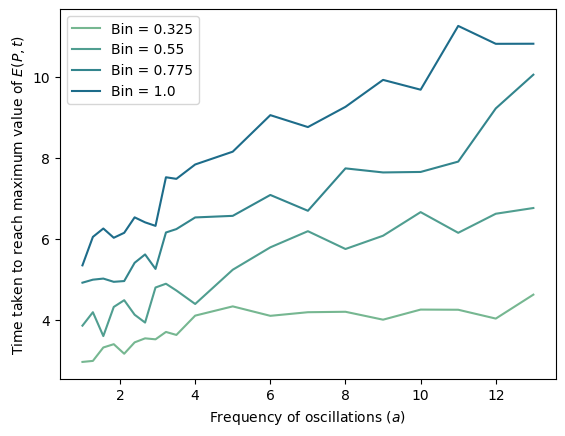

In [128]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ax.plot(ds, when_max[:,:-1]*1e-3, label = ["Bin = " + str(b) for b in bins[1:]])
ax.legend()
ax.legend()
ax.set_xlabel("Frequency of oscillations ($a$)")
ax.set_ylabel("Time taken to reach maximum value of $E(P,t)$")
plt.savefig("Runs/sigmoid_danger_pert/max_time.png", dpi = 300)

# Changing the escape parameter 

In [ ]:
es = np.linspace(0, 1, 10)
params = [np.linspace(0.1,1,5), 2000, 0.2*np.ones(5),3,0, 0, 2]
stables = []
for e in es:
    params[4] = e
    u_e, e_e, r_e = plot_results(params, "change_e", round(e, 2), 3*10**4)
    stables.append(np.min(np.where(np.diff(r_e)/r_e[1:] < 1e-6))*1e-3)

In [ ]:
plt.plot(stables)

# Changing the inital bin distribution

In [ ]:
ps = [[0.9,0.1,0,0,0], [0.8,0.1,0.1,0,0], [0.7,0.2,0.1,0,0], [0.6,0.2,0.1,0.1,0], [0.5,0.3,0.1,0.1,0], [0.4,0.3,0.2,0.1,0], [0.3,0.3,0.2,0.1,0.1], [0.1,0.2,0.3,0.4,0], [0.05,0.05,0,0,0.9]]
params = [np.linspace(0.1,1,5), 2000,0,3,0.9]
stables_bins = []
for n in ps:
    params[2] = np.array(n)
    u_b, e_b, r_b = plot_results(params, "change_bin_dis", n[0] , 3*10**4)
    stables_bins.append(np.min(np.where(np.diff(r_b)/r_b[1:] < 1e-6))*1e-3)


In [ ]:
plt.plot(stables_bins)

# Multiplication function

In [ ]:
ds = np.array([*np.linspace(1, 3.5, 10), *np.arange(4, 14)])
params = [np.linspace(0.1,1,5), 2000, 0.2*np.ones(5),0,0.9, 0,2]
sab = []
for d in ds:
    params[3] = d
    u_d, e_d, r_d = plot_results(params, "change_mul", round(d, 2), 3*10**4)
    sab.append(np.min(np.where(np.diff(r_d)/r_d[1:] < 1e-6))*1e-3)

In [ ]:
plt.plot(sab)

# With return

In [14]:
params = [np.linspace(0.1,1,5), 2000, 0.2*np.ones(5),9,0.9, 1, 2]
u_a, e_a, r_a = plot_results(params, "add_return", "allend", 3*10**4)

# Change s

In [ ]:
ds = np.arange(2,4,2)
params = [np.linspace(0.1,1,50), 10000, 1/50*np.ones(50),0.3,0.9, 0, 0]
fig = plt.figure()
colors = sns.color_palette("crest", 5)
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
for d in ds:
    params[6] = d
    sim = discrete_refugee(bins = params[0], num_people = params[1],  p = params[2], danger_time = params[3], escape_param = params[4], with_return = params[5], scope = params[6])
    safetys = sim.plot_safety(3*10**4)
    prop = d/100
    ax.plot(np.arange(3*10**4)*1e-3, safetys, linewidth = 3, label = "$\epsilon = {}$".format(prop), color = colors[-1])
    ax.set_xlabel("Time ($t$)")
    ax.set_ylabel("Average safety ($S(E,k,t)$)")
plt.legend()
plt.savefig("Safety.png", dpi = 300)

In [ ]:
ds = np.arange(1,6)
params = [np.linspace(0.1,1,5), 2000, 1/5*np.ones(5),0.3,0.9, 0, 0]
sa = []
for d in ds:
    params[6] = d
    sim = discrete_refugee(bins = params[0], num_people = params[1],  p = params[2], danger_time = params[3], escape_param = params[4], with_return = params[5], scope = params[6])
    u_sf, e_sf, r_sf = plot_results(params, "change_s_prop", round(d, 2), 3*10**4)
    sa.append(np.min(np.where(np.diff(r_sf)/r_sf[1:] < 1e-6))*1e-3)

# Integral of Danger for Escape

In [ ]:
d = "threshold"
params = [np.linspace(0.1,1,5), 2000, 1/5*np.ones(5),3,0.9, 0, 2]
sim = discrete_refugee(bins = params[0], num_people = params[1],  p = params[2], danger_time = params[3], escape_param = params[4], with_return = params[5], scope = params[6])
u_st, e_st, r_st = plot_results(params, "change_e_intg", d, 3*10**4)

In [ ]:
d = "standard"
params = [np.linspace(0.1,1,5), 2000, 1/5*np.ones(5),3,0.9, 0, 2]
sim = discrete_refugee(bins = params[0], num_people = params[1],  p = params[2], danger_time = params[3], escape_param = params[4], with_return = params[5], scope = params[6])
u_st, e_st, r_st = plot_results(params, "change_e_intg", d, 3*10**4)

In [ ]:
d = "weighted_frac"
params = [np.linspace(0.1,1,5), 2000, 1/5*np.ones(5),3,0.9, 0, 2]
sim = discrete_refugee(bins = params[0], num_people = params[1],  p = params[2], danger_time = params[3], escape_param = params[4], with_return = params[5], scope = params[6])
u_st, e_st, r_st = plot_results(params, "change_e_intg", d, 3*10**4)

In [ ]:
d = "weighted_e"
params = [np.linspace(0.1,1,5), 2000, 1/5*np.ones(5),3,0.9, 0, 2]
sim = discrete_refugee(bins = params[0], num_people = params[1],  p = params[2], danger_time = params[3], escape_param = params[4], with_return = params[5], scope = params[6])
u_st, e_st, r_st = plot_results(params, "change_e_intg", d, 3*10**4)

# Many random states 


In [71]:
instances = 50
niters = 3*10**4
params = [np.linspace(0.1,1,5), 2000, [], 0, 0.9, 0, 2, "two-spike", "threshold", "all_start"]
u_overall = np.zeros((niters ,5*instances))
e_overall = np.zeros((niters ,5*instances))
r_overall = np.zeros((niters, instances))
for i in range(instances): 
    test = discrete_refugee(*params)
    u_test, e_test, r_test = test.move(niters)
    u_overall[:,5*i : 5*i + 5] = u_test
    e_overall[:,5*i : 5*i + 5] = e_test
    r_overall[:,i] = r_test

Text(0, 0.5, '# People')

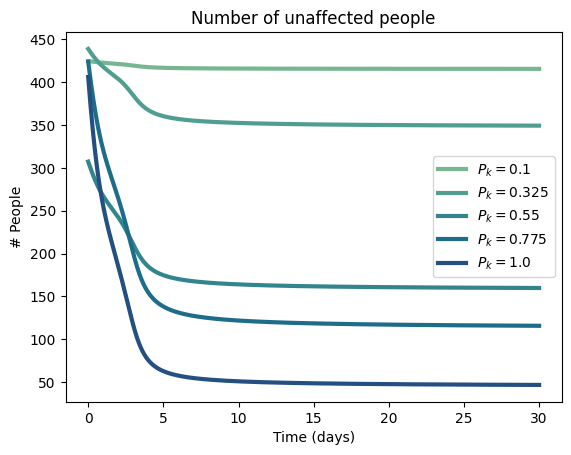

In [72]:
u_collapsed = np.transpose(np.array([np.mean(u_overall[:, i::5],axis = 1) for i in range(5)]))
colors = sns.color_palette("crest", 5)


fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ax.plot(np.arange(niters)*1e-3, u_collapsed, linewidth = 3, label = ["$P_k = " + str(i) + "$" for i in test.bins])
ax.set_title("Number of unaffected people")
ax.legend()
ax.set_xlabel("Time (days)")
ax.set_ylabel("# People")


Text(0, 0.5, '# People')

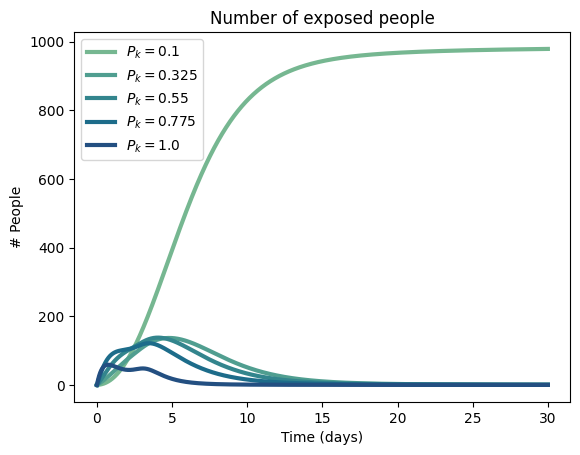

In [73]:
e_collapsed = np.transpose(np.array([np.mean(e_overall[:, i::5],axis = 1) for i in range(5)]))
colors = sns.color_palette("crest", 5)


fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ax.plot(np.arange(niters)*1e-3, e_collapsed, linewidth = 3, label = ["$P_k = " + str(i) + "$" for i in test.bins])
ax.set_title("Number of exposed people")
ax.legend()
ax.set_xlabel("Time (days)")
ax.set_ylabel("# People")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '# People')

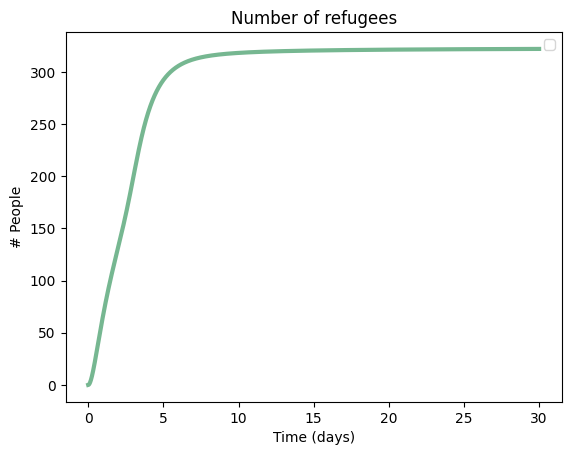

In [74]:
r_collapsed = np.transpose(np.array([np.mean(r_overall,axis = 1)]))
colors = sns.color_palette("crest", 5)


fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ax.plot(np.arange(niters)*1e-3, r_collapsed, linewidth = 3)
ax.set_title("Number of refugees")
ax.legend()
ax.set_xlabel("Time (days)")
ax.set_ylabel("# People")

# Rate of change of R

In [ ]:
fig = plt.figure()
colors = sns.color_palette("crest", 5)
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
bins = np.linspace(0,1,1000)
def indicator(bin):
    if bin <= 0.1:
        return 0
    elif bin <= 0.25:
        return 0.2
    elif bin <= 0.3:
        return 0.3
    elif bin <= 0.5:
        return 0.4
    elif bin <= 0.7:
        return 0.6
    elif bin <= 0.8:
        return 0.8 
    else:
        return 1
ind = []
for b in bins: ind.append(indicator(b))
ax.plot(bins, ind, color = colors[-1], linewidth = 3)
ax.set_xlabel("$P$")
ax.set_ylabel("$\gamma$")
plt.savefig("danger/indicator" + ".png", dpi = 300)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_prop_cycle('color', colors)
ts = np.arange(0,3*10**4)*1e-3
bins = np.linspace(0.1,1,5)
def dang(t, bin):
    return 0.5*bin/(1 + (t - 3)**2) + 0.5*bin/(1 + (t - 7)**2)
for i in bins: ax.plot(ts, dang(ts,i), linewidth = 3, label = "Bin = " + str(i))
ax.legend()
ax.set_xlabel("Time (days?)")
ax.set_ylabel("Danger")
fig.savefig("DoubleBump.png", dpi = 300)


In [ ]:
from scipy.integrate import quad
fig = plt.figure()
ax = fig.add_subplot()
colors = sns.color_palette("crest", 5)
ax.set_prop_cycle('color', colors)
ts = np.arange(0,3*10**4)*1e-3
bins = np.linspace(0.1,1,5)
def dang(t, bin):
    return (0.5*bin/(1 + (t - 3)**2) + 0.5*bin/(1 + (t - 2.5)**2))
vals = []
first_time = True
funcs  = [0]
lag = 3
for t in ts:
    cond = np.mean([dang(t,b) for b in bins]) < 0.2
    if cond and first_time:
        if t > lag:
            t0 = t
            first_time = False
        else:
            cond = 0
    elif not cond and not first_time:
        first_time = True
    vals.append(np.mean([dang(t,b) for b in bins]))
    if cond:
        funcs.append(cond*(t - t0)*0.01)
    else:
        funcs.append(funcs[-1]/(1 + 1e-3))


# fig.savefig("intgamma_laguerre.png", dpi = 300)
ax.plot(ts, np.mean(dang(ts,bins)), linewidth = 3)
ax.plot(ts, funcs[1:], linewidth = 3)
# ax.legend()
# ax.set_xlabel("Time (days?)")
# ax.set_ylabel("Danger")
# fig.savefig("DoubleBump.png", dpi = 300)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
colors = sns.color_palette("crest", 5)
ax.set_prop_cycle('color', colors)
ax.plot(ts, vals, linewidth = 3, color = colors[-1], label = "Mean $D(P,t)$")
ax.plot(ts, funcs[1:], linewidth = 3, color = colors[-2], label = "$\\varphi(t)$")
ax.plot(ts, 0.2*np.ones(len(ts)), linewidth = 1.5, linestyle = "dashed", color = "red", label = "Threshold")
ax.set_xlabel("Time (days?)")
ax.legend()
ax.set_ylabel("$\gamma$")
plt.savefig("varphi1.png", dpi = 300)

In [ ]:
params = [np.linspace(0.1,1,5), 2000, 1/5*np.ones(5),3,0.9, 0, 2]
sim = discrete_refugee(bins = params[0], num_people = params[1],  p = params[2], danger_time = params[3], escape_param = params[4], with_return = params[5], scope = params[6])
sim.plot_safety(3)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
colors = sns.color_palette("crest", 5)
ax.set_prop_cycle('color', colors)
ps = np.linspace(0,1,5)

init_dis = [400,400,400,400,400]

ts = np.arange(0,3*10**4)*1e-3
# # dangers = ps[:, None]/(1 + (ts[None, :] - 3)**2)
# # ax.imshow(dangers, aspect = 'auto')
# # fig.tight_layout()
# for i in testing.bins: ax.plot(np.arange(0,3*10**4)*1e-3,  0.5*i/(1 + (np.arange(0,3*10**4)*1e-3 - 3)**2), label = "Bin = " + str(i))
# ax.legend()
# ax.set_xlabel("Time (days?)")
# ax.set_ylabel("Danger")
# ax.set_title("Danger pressures")
# fig.savefig("Danger_Profilesi.png", dpi = 300)
np.sum(self.u[max(pos - 1,0): min(pos + 2, self.num_states)])/np.sum(self.initdis[max(pos - 1,0): min(pos + 2, self.num_states)])

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot()
# colors = sns.color_palette("crest", 5)
# ax.set_prop_cycle('color', colors)
# ps = np.linspace(0,1,10**3)
# # ts = np.arange(0,3*10**4)*1e-3
# # dangers = ps[:, None]/(1 + (ts[None, :] - 3)**2)
# # ax.imshow(dangers, aspect = 'auto')
# # fig.tight_layout()
# for i in testing.bins: ax.plot(np.arange(0,3*10**4)*1e-3,  0.5*i/(1 + (np.arange(0,3*10**4)*1e-3 - 3)**2), label = "Bin = " + str(i))
# ax.legend()
# ax.set_xlabel("Time (days?)")
# ax.set_ylabel("Danger")
# ax.set_title("Danger pressures")
# fig.savefig("Danger_Profilesi.png", dpi = 300)

# # fig = plt.figure()
# # ax = fig.add_subplot()
# # ax.set_prop_cycle('color', colors)
# # for i in testing.bins: ax.plot(np.arange(0,3*10**4)*1e-3, 0.5*i/(1 + (np.arange(0,3*10**4)*1e-3 - 3)**2) + 0.5*i/(1 + (np.arange(0,3*10**4)*1e-3 - 7)**2), label = "Bin = " + str(i))
# # ax.legend()
# # ax.set_xlabel("Time (days?)")
# # ax.set_ylabel("Danger")
# # fig.savefig("Danger_Profiles_2.png", dpi = 300)
# # print(testing.bins)


In [ ]:
# danger_times = np.arange(2.5,11.5, 0.5)
# colors = sns.color_palette("crest", 5)
# time = np.arange(0,3*10**4)*1e-3
# for d in danger_times:
#     fig = plt.figure()
#     ax = fig.add_subplot()
#     ax.set_prop_cycle('color', colors)
#     for i,b in enumerate(np.linspace(0.1,1.1,5)): ax.plot(time, np.minimum(b*np.sin(time - 2)/2 + b + b*np.sin(time - d)/2, 1), label = "Bin " + str(i), linewidth = 3)
#     ax.legend()
#     ax.set_title("Danger profile: $d = " + str(d) + "$")
#     plt.savefig("danger/danger" + str(d) + ".png", dpi = 300)
#     plt.close(fig) 

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot()
# ax.set_prop_cycle('color', colors)
# def indicator(bin):
#     if bin >= 0.9:
#         return 1
#     else:
#         return 0
# for b in testing.bins: ax.scatter(b, indicator(b), color = colors[-1], linewidth = 3)
# ax.set_xlabel("$P$")
# ax.set_ylabel("$\gamma$")
# plt.savefig("danger/indicator" + ".png", dpi = 300)